# Welter issue #5
## Predict Teff vs order
### Part 1- Dummy figure

Michael Gully-Santiago  
Monday, December 14, 2015  

Let's try it.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

### IGRINS data of ASASSN15qi

In [3]:
import h5py

In [4]:
f = h5py.File("../data/reduced/LkCa4_IGRINS_K.hdf5", "r")
K = {key:np.array(f[key]) for key in f.keys()}
f.close()

f = h5py.File("../data/reduced/LkCa4_IGRINS_H.hdf5", "r")
H = {key:np.array(f[key]) for key in f.keys()}
f.close()

In [5]:
K['wls'].shape

(26, 2048)

### Telluric absorption

In [6]:
import pandas as pd

In [7]:
tell = pd.read_csv('~/GitHub/plp/master_calib/TelluricModel.dat', sep=' ', names = ['wls', 'trans'])

In [8]:
tell['wls'] = tell['wls'] * 10.0 #convert to angstroms
tell.head()

,wls,trans
0,13999.994558,2.026157e-15
1,14000.024558,1.795465e-15
2,14000.054558,1.657147e-15
3,14000.084558,1.327971e-15
4,14000.114558,1.034897e-15


## Meta

In [9]:
K_orders, H_orders = pd.DataFrame(), pd.DataFrame()

In [10]:
K_orders['wl_start']=[np.floor(min(wl)) for wl in K['wls']]
K_orders['wl_end']=[np.floor(max(wl)) for wl in K['wls']]
K_orders['band']='K'
H_orders['wl_start']=[np.floor(min(wl)) for wl in H['wls']]
H_orders['wl_end']=[np.floor(max(wl)) for wl in H['wls']]
H_orders['band']='H'

In [11]:
orders = H_orders.append(K_orders)

### Calculate average transmission per order

In [12]:
N_orders = len(orders.wl_start)

In [13]:
orders['number'] = orders.index.values

In [14]:
orders.reset_index(inplace=True)

In [15]:
del orders['index']

In [16]:
orders['tell_trans'] = 0.0

In [17]:
for i in range(N_orders):
    ti = (tell.wls > orders.wl_start[i]) & (tell.wls < orders.wl_end[i])
    orders.set_value(i, 'tell_trans', np.mean(tell.trans[ti.values]))

In [26]:
orders.head()

,wl_start,wl_end,band,number,tell_trans,wl_center
0,18092,18346,H,0,0.117487,18219.0
1,17914,18165,H,1,0.342583,18039.5
2,17739,17988,H,2,0.666035,17863.5
3,17568,17815,H,3,0.827089,17691.5
4,17400,17645,H,4,0.904758,17522.5


## Plot it

In [19]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

In [20]:
orders.keys()

Index(['wl_start', 'wl_end', 'band', 'number', 'tell_trans'], dtype='object')

Central wavelength

In [21]:
orders['wl_center'] = (orders.wl_end + orders.wl_start) /2.0

In [22]:
orders.keys()

Index(['wl_start', 'wl_end', 'band', 'number', 'tell_trans', 'wl_center'], dtype='object')

Warmer photosphere

In [23]:
teff_mean = 4100.0
teff_unc  = 100.0
teff_means  = teff_mean * np.ones(N_orders) 
teff_uncs = teff_unc * np.random.normal(size=N_orders)
teff_iid  = teff_means + teff_uncs
teff_unc_het = teff_unc * 1.0 / orders.tell_trans.values
teff_uncs_het = teff_unc_het * np.random.normal(size=N_orders)
teff_het  = teff_means + teff_uncs_het

Cooler photosphere

In [24]:
teff_mean_b = 3500.0
teff_unc_b  = 100.0
teff_means_b  = teff_mean_b * np.ones(N_orders) 
teff_uncs_b = teff_unc_b * np.random.normal(size=N_orders)
teff_iid_b  = teff_means_b + teff_uncs_b
teff_unc_het_b = teff_unc_b * 1.0 / orders.tell_trans.values
teff_uncs_het_b = teff_unc_het_b * np.random.normal(size=N_orders)
teff_het_b  = teff_means_b + teff_uncs_het_b

Plot the telluric spectrum.

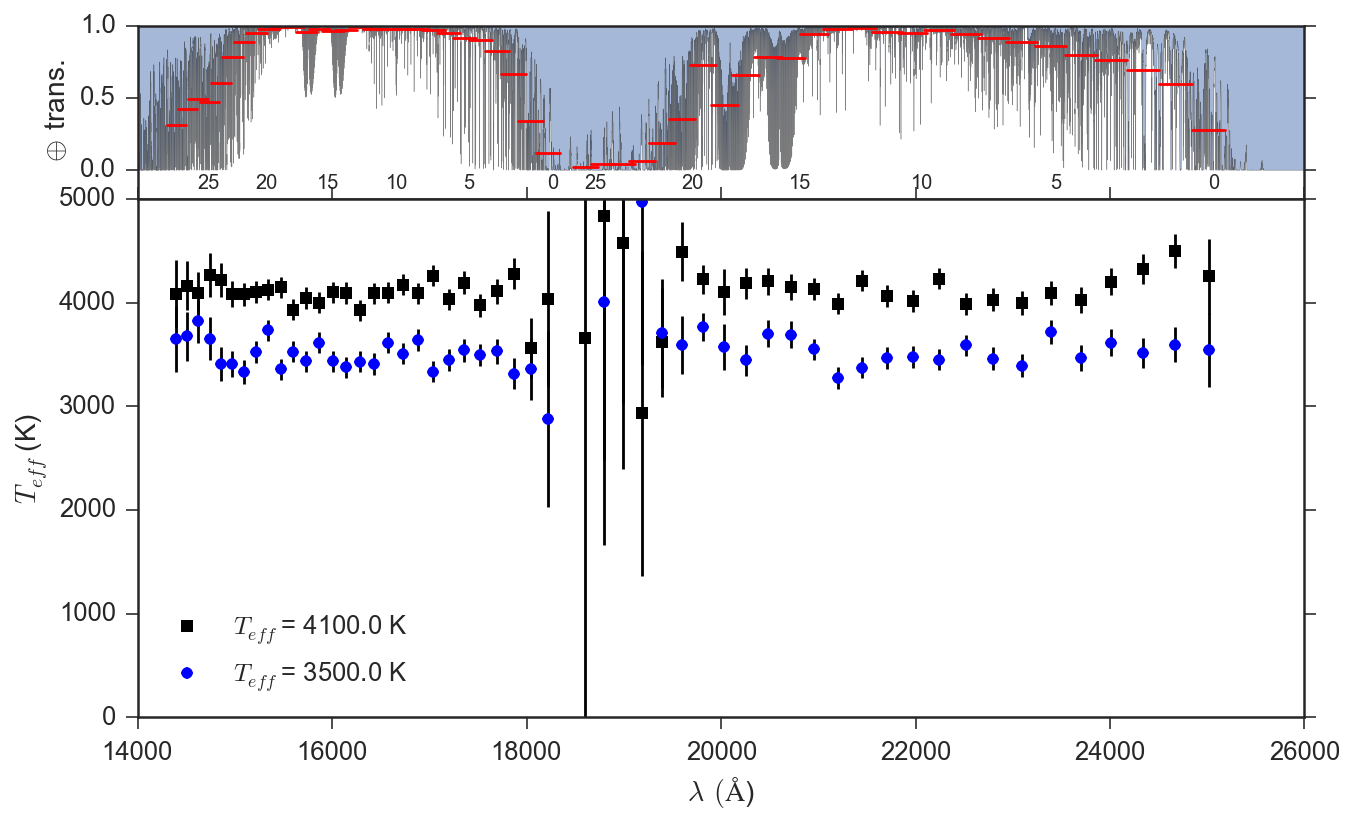

In [27]:
#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
#text_pos = 500.0 + 20.0*np.arange(N_orders)    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.number.values[i]))
    
    
ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])
label1 = "$T_{eff}$" +" = {} K ".format(teff_mean)
ax.errorbar(orders.wl_center, teff_het, yerr=teff_unc_het, fmt='k.')
ax.plot(orders.wl_center, teff_het, 'ks', label=label1 )

label2 = "$T_{eff}$" +" = {} K ".format(teff_mean_b)
ax.errorbar(orders.wl_center, teff_het_b, yerr=teff_unc_het_b, fmt='k.')
ax.plot(orders.wl_center, teff_het_b, 'bo', label=label2)

ax.set_ylim(0, 5000)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$T_{eff}$ (K)')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

plt.savefig('../document/figures/teff_vs_order.pdf', bbox_inches='tight')